<img style ="float:right" src = "https://d1vwxdpzbgdqj.cloudfront.net/s3-public-images/learning-partners/greatlearning-brand.svg" width=15%>

# **Estudio de caso: Sistema de recomendación de restaurantes de Yelp**

---------------
## **Contexto**
---------------

**Yelp** se fundó en **2004** para ayudar a las personas a encontrar **grandes negocios locales**. En la actualidad, el sitio web y su aplicación móvil publican reseñas de fuentes múltiples sobre negocios locales, así como ciertos metadatos sobre ellos que pueden ayudar en el **proceso de toma de decisiones** del cliente. Yelp utiliza software automatizado para recomendar las **más útiles** y las **reseñas confiables** para la comunidad de Yelp a partir de un conjunto de datos tan grande y diverso.

El conjunto de datos de Yelp es una gran colección de reseñas de usuarios, metadatos comerciales, registros comerciales, datos de redes sociales de usuarios, consejos de usuarios para empresas en 10 ciudades repartidas en **4 países**. El conjunto de datos original es muy grande con ~ 11 GB de datos. En este caso de estudio, solo usaremos un subconjunto de datos debido a las limitaciones del hardware.

-----------------
## **Objetivo**
-----------------

En este caso de estudio, construiremos cuatro tipos de sistemas de recomendación:
- **Sistema de recomendación basado en conocimientos/rango**
- **Filtrado colaborativo basado en la similitud**
- **Filtrado colaborativo basado en factorización matricial**
- **Sistema de recomendación basado en clustering**


-----------------
## **Conjunto de datos**
-----------------

De los muchos atributos disponibles en los datos de las reseñas de yelp, solo usaremos los siguientes cuatro atributos:
- business_id
- business_name
- stars
- user_id

A veces, la instalación de la biblioteca *surprise*, que se usa para construir sistemas de recomendación, enfrenta problemas en Jupyter. Para evitar problemas, se recomienda utilizar **Google Colab** para este estudio de caso.

Comencemos montando la unidad de Google en Colab.

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importación de las bibliotecas necesarias y descripción general del conjunto de datos**

In [ ]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

### **Cargando los datos**

In [ ]:
# Importing the dataset
yelp_review = pd.read_csv('yelp_reviews.csv', usecols = ['user_id', 'business_id', 'business_name', 'stars'])

# Dropping the "business_name" column
data = yelp_review.drop("business_name", axis = 1)

Revisemos la **info** de los datos.

In [ ]:
# This method is used to get the info of the dataframe.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229907 entries, 0 to 229906
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  229907 non-null  object
 1   stars        229907 non-null  int64 
 2   user_id      229907 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


- Hay **2,29,907 filas** y **3 columnas** en los datos.

## **Exploración de datos**

Comencemos con la exploración de datos.

**Primero veremos los primeros cinco registros de los datos de yelp_review.**

In [ ]:
# The head method is used to display the first five records of the dataset
data.head()

,business_id,stars,user_id
0,9yKzy9PApeiPPOUJEtnvkg,5,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,5,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,4,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,5,uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,5,vYmM4KTsC8ZfQBg-j5MWkw


#### **Describa la distribución de calificaciones**

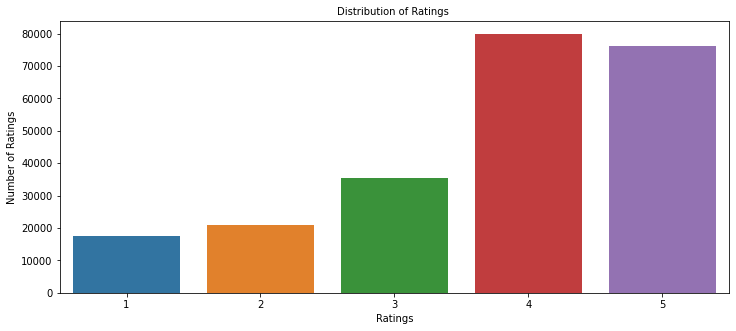

In [ ]:
# Fix the figure size
plt.figure(figsize = (12, 5))

ax = sns.countplot(x = "stars", data = data)

plt.tick_params(labelsize = 10)

plt.title("Distribution of Ratings ", fontsize = 10)

# Set the xlabel of the plot
plt.xlabel("Ratings", fontsize = 10)

# Set the ylabel of the plot
plt.ylabel("Number of Ratings", fontsize = 10)

# Display the plot
plt.show()

**Observaciones:**

* Los datos parecen estar **altamente sesgados** hacia la calificación**'4' y '5'.  **La calificación 5** es la segunda más alta en el conteo y casi la misma que el número de 4 de calificación.
* Podemos ver que muy pocas personas dan calificaciones **entre 1 y 3**. Muestra que las personas tienden a **no dar una calificación** a un restaurante que **no les gusta**.

##### **¿Cuál es el número total de usuarios únicos y restaurantes únicos**?

In [ ]:
# Number of unique users
data['user_id'].nunique()

45981

In [ ]:
# Number of unique restaurants
data['business_id'].nunique()

11537

**Observaciones:**
- Hay **45.981 usuarios únicos** en el conjunto de datos.
- Hay **11 537 restaurantes únicos** en el conjunto de datos.
- Según la cantidad de usuarios únicos y restaurantes, existe una **posibilidad de 45 981 * 11 537 = ~53 x 10^7 calificaciones** en el conjunto de datos. Pero **solo tenemos 2,29,907 calificaciones**, es decir, no todos los usuarios han calificado todos los restaurantes en el conjunto de datos. Y podemos construir un sistema de recomendación para recomendar un restaurante a los usuarios que no han visitado.

#### **¿Hay algún restaurante que haya sido visitado más de una vez por el mismo usuario?**

In [ ]:
# Find the sum of total ratings count by each user restaurant pair
data.groupby(['user_id', 'business_id']).count()['stars'].sum()

229907

- La **suma es igual al número total de observaciones** lo que implica que **solo hay interacción entre un par de restaurantes y un usuario**.

#### **¿Qué restaurante es el restaurante con más reseñas en el conjunto de datos?**

In [ ]:
data['business_id'].value_counts()

hW0Ne_HTHEAgGF1rAdmR-g    844
VVeogjZya58oiTxK7qUjAQ    794
JokKtdXU7zXHcr20Lrk29A    731
ntN85eu27C04nwyPa8IHtw    679
EWMwV5V9BxNs_U6nNVMeqw    645
                         ... 
-NbEHP2GHFNb5PnmJnd4qQ      3
QICgwHWhXIbihfcMKtws8g      3
sAwxt4I4gTiL-08nyarJbg      3
huzUWI5YqkJEEIudo0YiDg      3
SeCVec3f91bEdosAILE4JA      3
Name: business_id, Length: 11537, dtype: int64

**Observaciones:**
- El **restaurante con business_id hW0Ne_HTHEAgGF1rAdmR-g ha sido interactuado por la mayoría de los usuarios** que es **844** veces.
- Pero aún así, existe la posibilidad de **45,981-844 = 45,137** interacciones más ya que tenemos **45,981** usuarios únicos en nuestro conjunto de datos. Para los **usuarios restantes**, podemos crear un **sistema de recomendación** para predecir quién es más probable que visite este restaurante.

Además, de estas **844 interacciones**, también debemos considerar la distribución de calificaciones para verificar si este restaurante es el **restaurante que más gusta o el que menos gusta**.

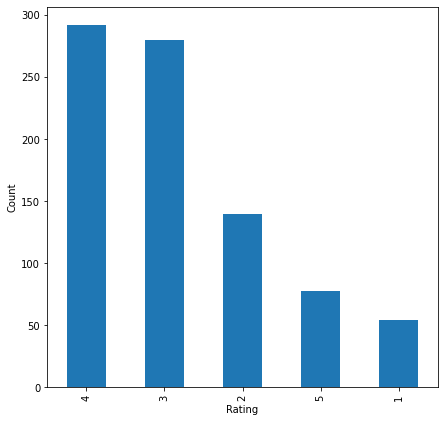

In [ ]:
# Plotting distributions of ratings for 844 interactions with given business_id
plt.figure(figsize = (7, 7))

data[data['business_id'] == "hW0Ne_HTHEAgGF1rAdmR-g"]['stars'].value_counts().plot(kind = 'bar')

# Name the xlabel of the plot
plt.xlabel('Rating')

# Name the ylabel of the plot
plt.ylabel('Count')

# Display the plot
plt.show()

**Observaciones:**
- Podemos ver que **este restaurante no es del agrado de muchos de los usuarios**, ya que el recuento de calificaciones 3 y 4 es más alto que el recuento de otras calificaciones.
- Puede haber restaurantes con interacciones muy altas, pero el recuento de calificaciones **1 y 2** puede ser mucho mayor que **4 o 5**, lo que implicaría que el restaurante no es del agrado de la mayoría de los usuarios.

#### **¿Qué usuario visitó más a cualquier restaurante en el conjunto de datos?**

In [ ]:
data['user_id'].value_counts()

fczQCSmaWF78toLEmb0Zsw    588
90a6z--_CUrl84aCzZyPsg    506
0CMz8YaO3f8xu4KqQgKb9Q    473
4ozupHULqGyO42s3zNUzOQ    442
joIzw_aUiNvBTuGoytrH7g    392
                         ... 
Oh9OOyDSGf4eNWGiNazh8g      1
Np9IEqnLmhRB2T5jumPTGw      1
g0-ejhzvo0ELNp04cUKWDg      1
M0lyA1jF0zrXZr5TXlioTQ      1
dDNfSFT0VApxPmURclX6_g      1
Name: user_id, Length: 45981, dtype: int64

**Observaciones:**
- El usuario con **user_id fczQCSmaWF78toLEmb0Zsw** ha interactuado con la mayor cantidad de restaurantes, es decir, **588** veces.
- Pero aun así, existe la posibilidad de **11 537-588 = 10 949** interacciones más, ya que tenemos **11 537 restaurantes únicos** en nuestro conjunto de datos. Para los **10,949** restaurantes restantes, podemos crear un sistema de recomendación para predecir qué restaurantes tienen más probabilidades de ser reseñados por este usuario.

**Como este conjunto de datos es muy grande y tiene 2,29,907 observaciones, no es computacionalmente posible construir un modelo usando esto. Además, muchos usuarios solo han calificado algunos restaurantes y también algunos restaurantes son calificados por muy pocos usuarios. Por lo tanto, podemos reducir el conjunto de datos considerando ciertas suposiciones lógicas.**

Aquí, tomaremos usuarios que hayan dado al menos 100 calificaciones, ya que preferimos tener una cierta cantidad de calificaciones de un restaurante.

In [ ]:
# Get the column containing the users
users = data.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1   

In [ ]:
# We want our users to have at least 100 ratings to be considered
RATINGS_CUTOFF = 100

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df_final = data.loc[ ~ data.user_id.isin(remove_users)]

**Ya que hemos explorado los datos, comencemos a construir los sistemas de recomendación**

## Modelo 1: **Construcción de un sistema de recomendación basado en rangos**

El sistema de recomendaciones basado en rangos proporciona recomendaciones basadas en los elementos más populares. Este tipo de sistema de recomendación es útil cuando tenemos problemas de **arranque en frío**. El inicio en frío se refiere al problema cuando **obtenemos un nuevo usuario en el sistema** y la máquina no puede recomendar un restaurante al nuevo usuario, ya que el usuario no tuvo interacciones históricas en el conjunto de datos. En esos casos, podemos usar un sistema de recomendación basado en rangos para recomendar un restaurante al nuevo usuario.

Para construir el sistema de recomendación basado en la clasificación, tomamos el **promedio** de todas las calificaciones proporcionadas a cada restaurante y luego las clasificamos según su calificación promedio.

In [ ]:
# Calculating average ratings
average_rating = data.groupby('business_id').mean()['stars']

# Calculating the count of ratings
count_rating = data.groupby('business_id').count()['stars']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

In [ ]:
# Let us see the first 5 records of the final_rating
final_rating.head()

,avg_rating,rating_count
business_id,,
--5jkZ3-nUPZxUvtcbr8Uw,4.545455,11
--BlvDO_RG2yElKu9XA1_g,4.162162,37
-0D_CYhlD2ILkmLR0pBmnA,4.000000,5
-0QBrNvhrPQCaeo7mTo0zQ,4.333333,3
-0bUDim5OGuv8R0Qqq6J4A,2.333333,6


Ahora, creemos una función para encontrar el **mejor restaurante n** para una recomendación basada en las calificaciones promedio del restaurante. También podemos agregar un **umbral para un número mínimo de visitas** para que un restaurante sea considerado para recomendación.

In [ ]:
def top_n_restaurant(data, n, min_interaction = 100):
    
    # Finding restautants with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)
    
    return recommendations.index[:n]

Podemos **usar esta función con diferentes valores de *n* e interacciones mínimas** para recomendar restaurantes.

#### **Recomendación de los 5 mejores restaurantes con 50 interacciones mínimas según la popularidad.**

In [ ]:
list(top_n_restaurant(final_rating, 5, 50))

['8HQ8clouLGgee99KkR4vXA',
 'CKjcewWeWvdJ7TzOQbZOIw',
 '97Z7j4vH0kfzL10AONi4uA',
 '_TekkyyFeX_8MBepPIxuTg',
 'L-uPZxooP_ziXCtRrWi8Pw']

Ahora que hemos visto **cómo aplicar el Sistema de recomendación basado en rangos**, apliquemos el **Sistema de recomendación basado en filtrado colaborativo**.

## **Sistema de recomendación basado en filtrado colaborativo**.

En este tipo de sistema de recomendación, **no necesitamos ninguna información** sobre los usuarios o elementos. Solo necesitamos datos de interacción de elementos del usuario para construir un sistema de recomendación colaborativo. Por ejemplo:
<ol>
    <li><b>Ratings</b> proporcionada por los usuarios. Por ejemplo: calificaciones de libros en goodread, calificaciones de películas en imdb, etc.</li>
    <li><b>Likes</b> de usuarios en diferentes publicaciones de facebook, me gusta en videos de youtube.</li>
    <li><b>Use/buying</b> de un producto por parte de los usuarios. Por ejemplo, comprar diferentes elementos en sitios de comercio electrónico.</li>
    <li><b>Reading</b> de elementos de lectores en varios blogs.</li>
</ol>

#### Tipos de filtrado colaborativo

- Basado en similitud/vecindario
  * Basado en similitud usuario-usuario
  * Basado en la similitud elemento-elemento
- Basado en modelos

### **Creación de un sistema de recomendación basado en la similitud usuario-usuario.**

- A continuación, estamos construyendo **sistemas de recomendación basados ​​en la similitud** usando la similitud del `coseno` y usando **KNN para encontrar usuarios similares** que son los vecinos más cercanos al usuario dado.
- Usaremos una nueva biblioteca - `surprise` para construir los modelos restantes, primero importemos las clases y funciones necesarias de esta biblioteca.
- Utilice el siguiente código para `instalar la biblioteca surprise `. Solo lo haces **una vez** mientras ejecutas el código por primera vez.

**!pip instala surprise**

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing ratings, data should be in structure - user; item; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Antes de construir los sistemas de recomendación, comprendamos algunas terminologías básicas que usaremos aquí.**

**Elemento relevante:** Un elemento (producto en este caso) que en realidad **está calificado más alto que el umbral de calificación (aquí 3.5)** es relevante, si el **la calificación real está por debajo del umbral, entonces es un elemento no relevante**.

**Elemento recomendado:** Un elemento cuya **calificación prevista es superior al umbral (aquí 3.5) es un elemento recomendado**, si la **calificación prevista está por debajo del umbral entonces ese producto no será recomendado al usuario**.

**Falso Negativo (FN):** Es la **frecuencia de elementos relevantes que no se recomiendan al usuario**. Si los elementos relevantes no se recomiendan al usuario, es posible que el usuario no compre el producto/elemento. Esto daría lugar a la **pérdida de oportunidades para el proveedor de servicios**, que a la empresa le gustaría minimizar.

**Falso Positivo (FP):** Es la **frecuencia de elementos recomendados que en realidad no son relevantes**. En este caso, el sistema de recomendación no está haciendo un buen trabajo al encontrar y recomendar los elementos relevantes al usuario. Esto daría como resultado **pérdida de recursos para el proveedor de servicios**, que también les gustaría minimizar.

**Recall:** Es la **fracción de elementos realmente relevantes que se recomiendan al usuario**, es decir, si de 10 productos relevantes, 6 se recomiendan al usuario, entonces recuerda es 0,60. Cuanto mayor sea el valor de recall mejor es el modelo. Es una de las métricas para realizar la evaluación del rendimiento de los modelos de clasificación.

**Precisión:** Es la **fracción de elementos recomendados que son realmente relevantes**, es decir, si de 10 elementos recomendados, el usuario considera que 6 son relevantes, entonces la precisión es 0,60. Cuanto mayor sea el valor de la precisión mejor es el modelo. Es una de las métricas para realizar la evaluación del rendimiento de los modelos de clasificación.

**Al hacer un sistema de recomendación, se acostumbra observar el desempeño del modelo. En términos de cuántas recomendaciones son relevantes y viceversa, a continuación se presentan algunas de las métricas de rendimiento más utilizadas en la evaluación de los sistemas de recomendación.**

### **Precisión@k, recall@k y puntuación F1@k**

**Precisión@k**: es la **fracción de los elementos recomendados que son relevantes en las predicciones `top k`**. El valor de k es el número de recomendaciones a proporcionar al usuario. Se puede elegir un número variable de recomendaciones para dar a un usuario único.


**Recall@k**: es la **fracción de elementos relevantes que se recomiendan al usuario en las predicciones `top k`**.

**F1-score@k** - Es la **media armónica de Precision@k y Recall@k**. Cuando **precisión@k y recall@k ambos parecen ser importantes** entonces es útil usar esta métrica porque es representativa de ambos.

### **Algunas funciones útiles**

- La siguiente función toma el **modelo de recomendación** como entrada y proporciona la **precisión@k y recall@k** para ese modelo.
- Para calcular **precisión y recall**, se tienen en cuenta las predicciones **top k** para cada usuario.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Returns precision and recall at k metrics for each user."""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant. When n_rec_k is 0, 
        # Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended. When n_rel is 0, 
        # Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2*precision * recall) / (precision + recall), 3))

A continuación, estamos cargando el **conjunto de datos**, que es un **Dataframe de pandas**, en un **formato diferente llamado `surprise.dataset.DatasetAutoFolds`** que es requerido por esta biblioteca. Para hacer esto estaremos **usando las clases `Reader` y `Dataset`**.

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the dataset
data = Dataset.load_from_df(df_final[['user_id', 'business_id', 'stars']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

- Ahora estamos **listos para construir el primer sistema de recomendación basado en la similitud de referencia** utilizando la similitud del coseno.
- **KNNBasic** es un algoritmo que también está **asociado con el paquete *surprise***, se usa para encontrar los **elementos similares deseados entre un conjunto determinado de elementos<**>.

- Para calcular la **precisión y recall**, se toma un **umbral de 3.5 y un valor k de 10 para las calificaciones recomendadas y relevantes**.
- En el **caso actual, tanto la precisión como la recall deben optimizarse, ya que el proveedor de servicios desearía minimizar las pérdidas analizadas** anteriormente. Por lo tanto, la medida de rendimiento correcta es la **puntuación F_1**.

## Modelo 2: **Creación de un modelo de filtrado colaborativo usuario-usuario**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_user_user)

RMSE: 1.0409
Precision:  0.773
Recall:  0.417
F_1 score:  0.542


- Hemos calculado **RMSE** para verificar **qué tan lejos están las calificaciones generales pronosticadas** de las **calificaciones reales**.
- Interpretación de recall: estamos obteniendo un **valor de recall de casi 0.42**, lo que significa que de **todos los restaurantes relevantes, el 42 % son recomendados**.
- Interpretación de precisión: estamos obteniendo una **precisión de casi 0.773**, lo que significa que **de todos los restaurantes recomendados, el 77.3 % son relevantes**.
- Aquí, la **puntuación F_1** del **modelo de referencia es casi 0.542**. Indica que **los restaurantes recomendados en su mayoría fueron relevantes y se recomendaron restaurantes relevantes** al usuario. Intentaremos mejorar esto más adelante usando **GridSearchCV ajustando diferentes hiperparámetros** de este algoritmo.

Ahora **predigamos la calificación para un usuario con `userId = rLtl8ZkDX5vH5nAx9C3q5Q` y `businessId = 9yKzy9PApeiPPOUJEtnvkg`** como se muestra a continuación.

In [ ]:
# Predicting rating for a sample user with a visited restaurant
sim_user_user.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.77   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.7675091038953616, details={'actual_k': 16, 'was_impossible': False})

- El resultado anterior muestra que **la calificación real para este par de usuario-elemento es 5 y la calificación pronosticada es 3.77** según el **modelo de referencia basado en la similitud usuario-usuario**. Esto implica que el modelo está subestimando las calificaciones.

A continuación, **predecimos la calificación para el mismo `userId = rLtl8ZkDX5vH5nAx9C3q5Q` pero para un restaurante que este usuario aún no ha visto, es decir, `business_id = zp713qNhx8d9KCJJnrw1xA`**

In [ ]:
# Predicting rating for a sample user with a restaurant that is not-visited by the user
sim_user_user.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.87   {'actual_k': 28, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.873369257511826, details={'actual_k': 28, 'was_impossible': False})

- Como podemos ver, la calificación estimada para este par de usuario-elemento es 3.87 según este modelo de referencia basado en la similitud.

### **Mejorando el sistema de recomendación basado en la similitud ajustando sus hiperparámetros**

A continuación, ajustaremos hiperparámetros para el algoritmo `KNNBasic`. Tratemos de entender algunos de los hiperparámetros del algoritmo KNNBasic:

- **k** (int) – El número (máximo) de vecinos a tener en cuenta para la agregación (ver esta nota). El valor predeterminado es 40.
- **min_k** (int) – El número mínimo de vecinos a tener en cuenta para la agregación. Si no hay suficientes vecinos, la predicción se establece en la media global de todas las calificaciones. El valor predeterminado es 1.
- **sim_options** (dict) – Un diccionario de opciones para la medida de similitud. Hay cuatro medidas de similitud disponibles en librerí a *surprise*:
    - coseno
    - msd (predeterminado)
    - pearson
    - pearson baseline
    
Para obtener más detalles, consulte la documentación oficial https://surprise.readthedocs.io/en/stable/knn_inspired.html

In [ ]:
# Setting up the parameters grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.014401876904966
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': True}}


Una vez que la búsqueda en cuadrícula está **completa**, podemos obtener los **valores óptimos para cada uno de esos hiperparámetros** como se muestra arriba.

Ahora, construyamos el **modelo final mediante el uso de valores ajustados de los hiperparámetros** que recibimos mediante el uso de **validación cruzada de búsqueda en cuadrícula**.

In [ ]:
# Using the optimal similarity measure for user-user-based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0060
Precision:  0.762
Recall:  0.413
F_1 score:  0.536


- Podemos ver desde arriba que después de ajustar los hiperparámetros, la puntuación **F_1 del modelo ajustado se ha reducido un poco en comparación con el modelo de referencia.**

Vamos ahora a **predecir la calificación para un usuario con `userId` = "rLtl8ZkDX5vH5nAx9C3q5Q" y business_id = "9yKzy9PApeiPPOUJEtnvkg" con el modelo optimizado que se muestra a continuación**.

In [ ]:
sim_user_user_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.77   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.7675091038953616, details={'actual_k': 16, 'was_impossible': False})

A continuación, predecimos la calificación para el mismo **`userId = "rLtl8ZkDX5vH5nAx9C3q5Q"`** pero para un restaurante que este usuario **no ha visitado antes**, es decir, `business_id = zp713qNhx8d9KCJJnrw1xA` , utilizando el **modelo optimizado** como se muestra a continuación:

In [ ]:
sim_user_user_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.87   {'actual_k': 28, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.873369257511826, details={'actual_k': 28, 'was_impossible': False})

### **Identificación de usuarios similares a un usuario dado (vecinos más cercanos)**

También podemos encontrar **usuarios similares a un usuario determinado** o sus **vecinos más cercanos** basados ​​en este algoritmo KNNBasic. A continuación, encontramos los 5 usuarios más similares al primer usuario de la lista con identificación interna 0.

In [ ]:
# Here 0 is the internal id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[18, 52, 79, 97, 103]

### **Implementación del algoritmo de recomendación basado en el modelo KNNBasic optimizado**

A continuación, implementaremos una función donde los parámetros de entrada son:

- datos: un conjunto de datos de **calificación**.
- user_id: Un ID de usuario **para el que queremos las recomendaciones**.
- top_n: El **número de elementos que queremos recomendar**.
- algo: El algoritmo que queremos usar **para predecir las calificaciones**.
- El resultado de la función es un **conjunto de elementos top_n** recomendados para el ID de usuario dado en función del algoritmo dado.

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended restaurant ids
    recommendations = []
    
    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot_table(index = 'user_id', columns = 'business_id', values = 'stars')
    
    # Extracting those restaurant ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the restaurant ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    # Returing top n highest predicted rating restaurants for this user
    return recommendations[:top_n]

#### **Los 5 principales negocios/productos previstos para userId = "rLtl8ZkDX5vH5nAx9C3q5Q" con sistema de recomendación basado en similitudes**

In [ ]:
# Making top 5 recommendations for user_id "rLtl8ZkDX5vH5nAx9C3q5Q" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, sim_user_user)

In [ ]:
# Building the dataframe for above recommendations with columns "business_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['business_id', 'predicted_ratings'])

,business_id,predicted_ratings
0,--5jkZ3-nUPZxUvtcbr8Uw,5
1,-7XuLxfYwZ9x72mEKXdv0A,5
2,-A82xEVAjOYZtDdRQw1FQw,5
3,-CZ78c-H3tTxpP-uQ09CWw,5
4,-J0jhpG0rv4saq9OMh8gXw,5


### **Corrección de las calificaciones y clasificación de los productos/negocios anteriores**

Al comparar las calificaciones de dos productos, no son solo las **calificaciones** las que describen la **probabilidad del usuario para ese producto**. Junto con la calificación, el **número de usuarios que han visto ese producto** también se vuelve importante a considerar. Debido a esto, hemos calculado las **"calificaciones_corregidas"** para cada producto. Por lo general, cuanto mayor sea el **"rating_count" de un producto, más gustará a los usuarios**. Para interpretar el concepto anterior, un **producto calificado con 4 por 3 personas gusta menos en comparación con un producto calificado con 3 por 50 personas**. Se ha **encontrado empíricamente que la probabilidad del producto es directamente proporcional a la inversa de la raíz cuadrada del rating_count del producto**.

In [ ]:
def ranking_products(recommendations, final_rating):
    # Sort the products based on ratings count
    ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

    # Merge with the recommended businesses to get predicted ratings
    ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns = ['business_id', 'predicted_ratings']), on = 'business_id', how = 'inner')

    # Rank the businesses based on corrected ratings
    ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

    # Sort the businesses based on corrected ratings
    ranked_products = ranked_products.sort_values('corrected_ratings', ascending = False)
    
    return ranked_products

**Nota:** En la **fórmula de calificación corregida anteriormente**, podemos agregar la **cantidad `1 / np.sqrt(n)` en lugar de restarla a obtener predicciones más optimistas**. Pero aquí estamos **restando esta cantidad**, ya que hay algunos productos con calificaciones de 5 y **no podemos tener una calificación de más de 5 para un producto**.

In [ ]:
# Applying the ranking products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
0,--5jkZ3-nUPZxUvtcbr8Uw,11,5,4.698489
1,-J0jhpG0rv4saq9OMh8gXw,6,5,4.591752
2,-7XuLxfYwZ9x72mEKXdv0A,5,5,4.552786
3,-A82xEVAjOYZtDdRQw1FQw,5,5,4.552786
4,-CZ78c-H3tTxpP-uQ09CWw,3,5,4.422650


### Modelo 3: **Modelo de filtrado colaborativo de elemento de elemento de construcción**

* Arriba hemos visto **filtrado colaborativo basado en similitudes** donde se ha visto similitud **entre los usuarios**. Ahora analicemos el filtrado colaborativo basado en la similitud donde se observa similitud **entre los elementos**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0218
Precision:  0.663
Recall:  0.344
F_1 score:  0.453


- El modelo de referencia proporciona una puntuación F_1 de **alrededor del 45 %**. Intentaremos **mejorar esto más tarde usando GridSearchCV** ajustando diferentes hiperparámetros de este algoritmo.

Ahora **predigamos una calificación para un usuario con `userId = rLtl8ZkDX5vH5nAx9C3q5Q` y `business_Id = 9yKzy9PApeiPPOUJEtnvkg`** como se muestra a continuación. Aquí el usuario ya interactuó o visitó el restaurante con businessId "9yKzy9PApeiPPOUJEtnvkg".

In [ ]:
# Predicting rating for a sample user with a visited restaurant
sim_item_item.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.48   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.475, details={'actual_k': 40, 'was_impossible': False})

A continuación, **predecimos la calificación para el mismo `userId = rLtl8ZkDX5vH5nAx9C3q5Q` pero para un restaurante que este usuario aún no ha visitado, es decir, `business_id = zp713qNhx8d9KCJJnrw1xA`**

In [ ]:
# Predicting rating for a sample user with restaurant not visited by the user
sim_item_item.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.77   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.775, details={'actual_k': 40, 'was_impossible': False})

### **Mejora del sistema de recomendaciones basado en similitudes mediante el ajuste de sus hiperparámetros**

A continuación estaremos **afinando hiperparámetros para los algoritmos `KNNBasic`**.

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0090808269973346
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


Una vez que se completa la **búsqueda en cuadrícula**, podemos obtener los **valores óptimos para cada uno de esos hiperparámetros como se muestra arriba**

Ahora construyamos el **modelo final** usando **valores ajustados de los hiperparámetros** que recibimos usando la validación cruzada de búsqueda en cuadrícula.

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9986
Precision:  0.708
Recall:  0.375
F_1 score:  0.49


- Podemos ver desde arriba que después de ajustar los hiperparámetros, **la puntuación F_1 del modelo ajustado es mucho mejor que el modelo de referencia**. Además, hay una caída considerable en el valor de RMSE después de ajustar los hiperparámetros. Por lo tanto, el modelo sintonizado funciona mejor que el anterior.

Predigamos ahora la **calificación para un usuario con `userId = rLtl8ZkDX5vH5nAx9C3q5Q` y para `business_id = 9yKzy9PApeiPPOUJEtnvkg`** con el **modelo optimizado** como se muestra a continuación.

In [ ]:
sim_item_item_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 4.90   {'actual_k': 30, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=4.896024464831805, details={'actual_k': 30, 'was_impossible': False})

- Aquí, el modelo optimizado predice una buena calificación (casi **4.90**) para la empresa cuya calificación real es 5.

A continuación, **predecimos la calificación** para el mismo **`userId = rLtl8ZkDX5vH5nAx9C3q5Q`** pero para un restaurante que este usuario **no ha visitado antes**, es decir , `business_id == zp713qNhx8d9KCJJnrw1xA`, usando el modelo optimizado como se muestra a continuación:

In [ ]:
sim_item_item_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.71   {'actual_k': 30, 'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.705302758867788, details={'actual_k': 30, 'was_impossible': False})

- Para una empresa desconocida, el modelo predice una calificación de **3.71**.

### **Identificar elementos similares a un elemento dado (vecinos más cercanos)**

También podemos encontrar **elementos similares** a un elemento determinado o sus vecinos más cercanos en función de este **algoritmo KNNBasic**. A continuación, encontramos los 5 elementos más similares a los elementos con ID interna 0 según la métrica de distancia `msd`

In [ ]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[21, 27, 35, 51, 57]

#### **Los 5 principales negocios/productos previstos para userId = "rLtl8ZkDX5vH5nAx9C3q5Q" con un sistema de recomendaciones basado en similitudes.**

In [ ]:
# Making top 5 recommendations for user_id rLtl8ZkDX5vH5nAx9C3q5Q with similarity-based recommendation engine
recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "business_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['business_id', 'predicted_ratings'])

,business_id,predicted_ratings
0,5Q49MxuWJgXS649i7i2Iow,4.416667
1,SmY_Xw31b2xyzsKbimQiHQ,4.346154
2,N6ff0yyo9Cv_7XPz-YDoow,4.308696
3,UmFnmIoLCRe1ywY0bzpRrQ,4.307692
4,p204PQg45gECcYwxCAK1wA,4.307692


In [ ]:
# Applying the ranking_products function and sorting it based on corrected ratings
ranking_products(recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
1,5Q49MxuWJgXS649i7i2Iow,10,4.416667,4.100439
0,SmY_Xw31b2xyzsKbimQiHQ,15,4.346154,4.087955
2,N6ff0yyo9Cv_7XPz-YDoow,7,4.308696,3.930731
3,UmFnmIoLCRe1ywY0bzpRrQ,4,4.307692,3.807692
4,p204PQg45gECcYwxCAK1wA,3,4.307692,3.730342


Ahora que hemos visto los **algoritmos de filtrado colaborativo basados ​​en similitud**, pasemos a los **algoritmos de filtrado colaborativo basados ​​en modelos**.

### Modelo 4: **Construcción de un sistema de recomendación de filtrado colaborativo basado en modelos: factorización matricial**

El filtrado colaborativo basado en modelos es un **sistema de recomendaciones personalizadas**, las recomendaciones se basan en el comportamiento anterior del usuario y no dependen de ninguna información adicional. Usamos **características latentes** para encontrar recomendaciones para cada usuario.

### **Descomposición de valores singulares (SVD)**

SVD se utiliza para **calcular las características latentes** de la **matriz de interacción usuario-elemento**. Pero SVD no funciona cuando faltan valores en la **matriz de interacción usuario-elemento**.

### **Construcción de un sistema de recomendación de factorización de matriz de referencia**

In [ ]:
# Using SVD matrix factorization
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(svd)

RMSE: 0.9630
Precision:  0.77
Recall:  0.383
F_1 score:  0.512


- El modelo de referencia con el algoritmo está dando una buena puntuación F-1 (casi **51%**). Indica un buen desempeño del modelo.

Predigamos ahora la calificación para un usuario con **`userId = "rLtl8ZkDX5vH5nAx9C3q5Q`"** y **`business_id = "9yKzy9PApeiPPOUJEtnvkg"`** como se muestra a continuación. Aquí el usuario ya ha calificado.

In [ ]:
# Making the prediction
svd.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 4.16   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=4.155179595069889, details={'was_impossible': False})

Como podemos ver, **la calificación real** para este par de elementos de usuario es 5 y la calificación prevista también se acerca a eso. Parece que hemos subestimado la calificación. Intentaremos arreglar esto más tarde **ajustando los hiperparámetros** del modelo usando GridSearchCV.

A continuación, predecimos la calificación para el mismo `userId = rLtl8ZkDX5vH5nAx9C3q5Q` pero para un restaurante que este usuario no ha visto antes, es decir, `business_id = zp713qNhx8d9KCJJnrw1xA`, como se muestra a continuación:

In [ ]:
# Making prediction using the svd model
svd.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 4.09   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=4.09204353877637, details={'was_impossible': False})

Podemos ver que la **puntuación estimada** para este **par de usuario-elemento** es ~4.10 según este **modelo de referencia basado en la factorización matricial**.

### **Mejora del sistema de recomendación basado en la factorización de matrices mediante el ajuste de sus hiperparámetros.**

En SVD, la calificación se predice como -

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

Si se desconoce el usuario $u$, se supone que el sesgo $b_{u}$ y los factores $p_{u}$ son cero. Lo mismo aplica para el ítem $i$ con $b_{i}$ y $q_{i}$.

Para estimar todas las incógnitas, minimizamos el siguiente error cuadrático regularizado:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

La minimización se realiza mediante un **descenso de gradiente estocástico** muy sencillo:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

Hay muchos hiperparámetros para ajustar este algoritmo, puede encontrar una lista completa de hiperparámetros [aquí](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

A continuación, ajustaremos solo tres hiperparámetros:
- **n_epochs**: El número de iteraciones del algoritmo SVD.
- **lr_all**: La tasa de aprendizaje para todos los parámetros.
- **reg_all**: El término de regularización para todos los parámetros.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the model on the data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9583866559522352
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Una vez que se completa la **búsqueda en cuadrícula**, podemos obtener los **valores óptimos** para cada uno de esos hiperparámetros como se muestra arriba.

Ahora **construiremos el modelo final** usando **valores ajustados** de los hiperparámetros que recibimos usando la validación cruzada de búsqueda en cuadrícula.

In [ ]:
# Building the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(svd_optimized)

RMSE: 0.9507
Precision:  0.79
Recall:  0.402
F_1 score:  0.533


- Podemos ver desde arriba que el **modelo ajustado** muestra una puntuación F_1 ligeramente mejor que el modelo de referencia, también el RMSE ha bajado. Por lo tanto, el modelo ajustado funciona mejor que el modelo anterior.

Ahora predigamos una calificación para un usuario con `userId = rLtl8ZkDX5vH5nAx9C3q5Q` y `BusinessId = 9yKzy9PApeiPPOUJEtnvkg` con el modelo optimizado como se muestra a continuación.

In [ ]:
# Using svd_algo_optimized model to recommend for userId "rLtl8ZkDX5vH5nAx9C3q5Q" and business_Id 9yKzy9PApeiPPOUJEtnvkg
svd_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.91   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.9075441937737696, details={'was_impossible': False})

- La calificación pronosticada es buena aquí para un restaurante cuya calificación real es **5**. El modelo optimizado está dando una predicción bastante buena.

In [ ]:
# Using svd_optimized model to recommend for userId "rLtl8ZkDX5vH5nAx9C3q5Q" and businessId "zp713qNhx8d9KCJJnrw1xA" which the user has not visited
svd_optimized.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.96   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.963060797712287, details={'was_impossible': False})

- Para un restaurante que no visitado, la calificación otorgada por el modelo optimizado parece ser buena.

In [ ]:
# Getting top 5 recommendations for user_id rLtl8ZkDX5vH5nAx9C3q5Q using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, svd_optimized)

In [ ]:
pd.DataFrame(svd_recommendations, columns = ['business_id', 'predicted_ratings'])

,business_id,predicted_ratings
0,X3icXUyW9vS4UXY6V_MR4w,4.764319
1,GwSdGrvaXi4BdXNSWKn-EA,4.645138
2,97Z7j4vH0kfzL10AONi4uA,4.637496
3,4SviSw8uRF0ddj_HxUVnuA,4.623874
4,XRBTHOXaJK_AJ2wy5mX_1A,4.622570


In [ ]:
# Ranking products based on above recommendations
ranking_products(svd_recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
1,X3icXUyW9vS4UXY6V_MR4w,79,4.764319,4.651811
0,GwSdGrvaXi4BdXNSWKn-EA,153,4.645138,4.564293
2,97Z7j4vH0kfzL10AONi4uA,78,4.637496,4.524268
3,XRBTHOXaJK_AJ2wy5mX_1A,26,4.622570,4.426454
4,4SviSw8uRF0ddj_HxUVnuA,10,4.623874,4.307647


## Modelo 5: **Sistema de recomendación basado en clústeres**

En los **sistemas de recomendación basados ​​en agrupaciones**, exploramos las **similitudes y diferencias** en los gustos de las personas en los restaurantes en función de cómo califican a los diferentes restaurantes. Agrupamos a usuarios similares y recomendamos restaurantes a un usuario en función de las calificaciones de otros usuarios en el mismo grupo.

- **Co-clustering** es un conjunto de técnicas en **Cluster Analysis**. Dada alguna **matriz A, queremos agrupar filas de A y columnas de A simultáneamente**, esta es una tarea común para matrices de elementos de usuario.

- Como agrupa tanto las filas como las columnas simultáneamente, también se denomina **bi-clustering**. Para comprender el funcionamiento del algoritmo, deje que A sea una matriz m x n, el objetivo es generar co-clusters: un subconjunto de filas que exhiben un comportamiento similar en un subconjunto de columnas, o viceversa.

- El co-agrupamiento se define como dos funciones de mapa:
filas -> índices de clúster de filas
columnas -> índices de grupos de columnas
Estas funciones de mapa se aprenden simultáneamente. Es **diferente de otras técnicas de agrupamiento** donde agrupamos **primero las filas y luego las columnas**.

In [ ]:
# Using Co-Clustering algorithm
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the train set
clust_baseline.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clust_baseline)

RMSE: 1.0378
Precision:  0.765
Recall:  0.403
F_1 score:  0.528


* Hemos calculado **RMSE** para comprobar **qué tan lejos están las calificaciones generales previstas** de las **clasificaciones reales**.
* Aquí, la **puntuación F_1** del **modelo de referencia es casi 0,528**. Indica que **los restaurantes recomendados fueron relevantes y se recomendaron restaurantes relevantes en más de la mitad de las recomendaciones**. Intentaremos mejorar esto más adelante usando **GridSearchCV ajustando diferentes hiperparámetros** de este algoritmo.

Ahora **predigamos una calificación para un usuario con `userId = rLtl8ZkDX5vH5nAx9C3q5Q` y `business_Id = 9yKzy9PApeiPPOUJEtnvkg`** como se muestra a continuación. Aquí el usuario ya interactuó o visitó el restaurante con businessId "9yKzy9PApeiPPOUJEtnvkg".

In [ ]:
# Making prediction for user_id 4 and business_id 9483
clust_baseline.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.97   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.966289107885623, details={'was_impossible': False})

- Como podemos ver, la **puntuación real** para este **par de usuario-elemento es 5** y la **puntuación prevista es 3.97 según esta base de referencia basada en agrupación en clústeres modelo**. Parece que la modelo ha subestimado la calificación. Intentaremos arreglar esto más tarde ajustando los hiperparámetros del modelo usando GridSearchCV.

A continuación, **predecimos la calificación para el mismo `userId = rLtl8ZkDX5vH5nAx9C3q5Q` pero para un restaurante que este usuario aún no ha visitado, es decir, `business_id = zp713qNhx8d9KCJJnrw1xA`**

In [ ]:
# Making prediction for userid 4 and business_id 9980
clust_baseline.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.70   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.7039820276856474, details={'was_impossible': False})

- Podemos ver que la **calificación estimada** para este par de usuario-elemento es de 3.70 según este modelo de referencia basado en la agrupación conjunta.

### **Mejora del sistema de recomendaciones basado en agrupaciones mediante el ajuste de sus hiperparámetros**

A continuación, ajustaremos hiperparámetros para los algoritmos `CoClustering`. Tratemos de entender diferentes hiperparámetros de este algoritmo.

- **n_cltr_u** (int) – Número de **grupos de usuarios**. El valor predeterminado es 3.
- **n_cltr_i** (int) – Número de **grupos de elementos**. El valor predeterminado es 3.
- **n_epochs** (int) – Número de **iteración del ciclo de optimización**. El valor predeterminado es 20.
- **random_state** (int, instancia de RandomState de NumPy o Ninguno): determina el RNG que se utilizará para la inicialización. Si es int, random_state se usará como semilla para un nuevo RNG. Esto es útil para obtener la misma inicialización en varias llamadas a fit(). Si es una instancia de RandomState, esta misma instancia se usa como RNG. Si es Ninguno, se usa el RNG actual de numpy. El valor predeterminado es Ninguno.
- **verbose** (bool) – Si es Verdadero, se imprimirá el número de ciclo actual. El valor predeterminado es Falso.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [3, 4, 5, 6], 'n_cltr_i': [3, 4, 5, 6], 'n_epochs': [30, 40, 50]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Print the best RMSE score
print(gs.best_score['rmse'])

# Print the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0388440315195642
{'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 40}


Una vez que la búsqueda en cuadrícula está **completa**, podemos obtener los **valores óptimos** para cada uno de esos hiperparámetros, como se muestra arriba.

Ahora construiremos el **modelo final** usando valores ajustados de los hiperparámetros que recibimos usando la validación cruzada de búsqueda en cuadrícula.

In [ ]:
# Using tuned Coclustering algorithm
clust_tuned = CoClustering(n_cltr_u = 3,n_cltr_i = 3, n_epochs = 40, random_state = 1)

# Training the algorithm on the train set
clust_tuned.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clust_tuned)

RMSE: 1.0373
Precision:  0.764
Recall:  0.404
F_1 score:  0.529


- Podemos ver que la **puntuación F_1** para el **modelo de agrupación en clústeres ajustado** en el conjunto de pruebas es **comparable con la puntuación F_1** para la agrupación en clústeres conjunta de referencia modelo. El rendimiento del modelo no ha mejorado mucho.

Ahora **predigamos una calificación para un usuario con `userId = rLtl8ZkDX5vH5nAx9C3q5Q` y `business_Id = 9yKzy9PApeiPPOUJEtnvkg`** como se muestra a continuación. Aquí el usuario ya interactuó o visitó el restaurante con businessId "9yKzy9PApeiPPOUJEtnvkg".

In [ ]:
# Making prediction for user_id 4 and business_id 9483
clust_tuned.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "9yKzy9PApeiPPOUJEtnvkg", r_ui = 5, verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: 9yKzy9PApeiPPOUJEtnvkg r_ui = 5.00   est = 3.96   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='9yKzy9PApeiPPOUJEtnvkg', r_ui=5, est=3.9644335253991674, details={'was_impossible': False})

- Como podemos ver, la **puntuación real** para este **par de usuario-elemento es 5** y la **puntuación prevista es 3.96 según esta base de referencia basada en agrupación en clústeres modelo**. Parece que la modelo ha subestimado la calificación. Intentaremos arreglar esto más tarde ajustando los hiperparámetros del modelo usando GridSearchCV.

A continuación, **predecimos la calificación para el mismo `userId = rLtl8ZkDX5vH5nAx9C3q5Q` pero para un restaurante que este usuario aún no ha visitado, es decir, `business_id = zp713qNhx8d9KCJJnrw1xA`**

In [ ]:
# Making prediction for userid 4 and business_id 9980
clust_tuned.predict("rLtl8ZkDX5vH5nAx9C3q5Q", "zp713qNhx8d9KCJJnrw1xA", verbose = True)

user: rLtl8ZkDX5vH5nAx9C3q5Q item: zp713qNhx8d9KCJJnrw1xA r_ui = None   est = 3.73   {'was_impossible': False}


Prediction(uid='rLtl8ZkDX5vH5nAx9C3q5Q', iid='zp713qNhx8d9KCJJnrw1xA', r_ui=None, est=3.730191262361615, details={'was_impossible': False})

In [ ]:
# Getting top 5 recommendations for user_id 4 using "Co-clustering based optimized" algorithm
clustering_recommendations = get_recommendations(df_final, "rLtl8ZkDX5vH5nAx9C3q5Q", 5, clust_tuned)

In [ ]:
# Ranking restaurants based on above recommendations
ranking_products(clustering_recommendations, final_rating)

,business_id,rating_count,predicted_ratings,corrected_ratings
0,--5jkZ3-nUPZxUvtcbr8Uw,11,5,4.698489
1,-Mf4I8Jr_Vly37Z3Mgf0zQ,10,5,4.683772
2,-7XuLxfYwZ9x72mEKXdv0A,5,5,4.552786
3,-JYWpdJfMkqCTA_7fyz6Cw,4,5,4.500000
4,-CZ78c-H3tTxpP-uQ09CWw,3,5,4.422650


### **Conclusión**

En este caso de estudio, construimos sistemas de recomendación utilizando cinco algoritmos diferentes. Son los siguientes:
- Basado en rangos usando promedios
- Filtrado colaborativo basado en la similitud usuario-usuario
- Filtrado colaborativo basado en la similitud de elemento a elemento
- Filtrado colaborativo basado en modelos (factorización de matrices)
- Sistemas de recomendación basados ​​en agrupamiento

- Hemos visto en qué se diferencian entre sí y qué tipo de datos se necesitan para construir cada uno de estos sistemas de recomendación. Podemos combinar aún más todas las técnicas de recomendación que hemos visto.

- Para demostrar **"filtrado colaborativo basado en similitud usuario-usuario", "filtrado colaborativo basado en similitud elemento-elemento" y "filtrado colaborativo basado en modelo (factorización matricial)"**, se ha introducido la biblioteca, *surprise*. Para estos algoritmos **se aplica validación cruzada de búsqueda en cuadrícula para encontrar el mejor modelo de trabajo**, y con eso se realizan las**predicciones correspondientes**.

- **Para la evaluación del rendimiento** de estos modelos, se presentan en este caso de estudio: **precision@k y recall@k**. Con estas dos métricas, se calcula la **puntuación F_1** para cada modelo de trabajo.